# Multi Layered Perceptron (MLP) - A quick (re-)introduction usng PyTorch

In this notebook, we will train a simple MLP on the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) data set using PyTorch library

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init as weight_init
import matplotlib.pyplot as plt
import numpy as np
import random

from torch.utils.data import Subset

from loadFashionMNIST import FashionMNIST

torch.manual_seed(0)
np.random.seed(0)

### Selecting gpu device if cuda is available

In [2]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

device = torch.device("cuda" if use_cuda else "cpu")

Using PyTorch version: 0.4.1 CUDA: True


### Define data set

For the demo, we will consider only 1% (or 0.01 fraction) of the original training data. We will keep the entire test set as our test data.

In [3]:
train_dataset = FashionMNIST(split='train', frac=0.01)
test_dataset = FashionMNIST(split='test')

### Create a training and a validation data set from the given train split

We will split the given training data into train and val set based on 80-20 split

In [4]:
training_ratio = 0.8

length = len(train_dataset)
inds = np.arange(0, length)
random.shuffle(inds)
train_inds = inds[:round(training_ratio*length)]
val_inds = inds[round(training_ratio*length):]

train_set = Subset(train_dataset, train_inds)
val_set = Subset(train_dataset, val_inds)

### Visualize data set

Number of training data: 480
Number of validation data: 120
Number of test data: 10000
Image dimensions: torch.Size([1, 28, 28])


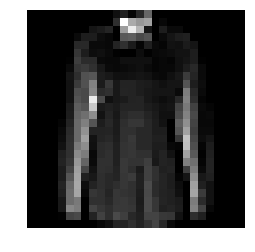

In [5]:
print('Number of training data: {}'.format(len(train_set)))
print('Number of validation data: {}'.format(len(val_set)))
print('Number of test data: {}'.format(len(test_dataset)))
print('Image dimensions: {}'.format(train_dataset[0][0].size()))
plt.figure()
plt.axis('off')
plt.imshow(train_dataset[0][0].squeeze().numpy(),cmap='gray')

### Define a data loader

In [6]:
batch_size = 10
# loading the train data set
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# loading the validation data set
test_loader = torch.utils.data.DataLoader(dataset=val_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# loading the test data set
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

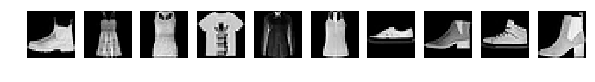

In [7]:
#Plotting 10 samples
for (X_train, y_train) in train_loader:
    pltsize=1
    plt.figure(figsize=(10*pltsize, pltsize))
    
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.axis('off')
        plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    break

### Define a simple MLP

Let's define the network as a Python class. This Python class inherits functions from _nn.module_.

There are three convenient functions that are defined in this class:

- ### **\__init__()**:
In this function, we shall declare all the layers of our neural network, including the number of neurons, non-linear activations, etc.

- ### **forward()**:
This is the function that is used to compute forward pass of the network. Here, we shall connect the different layers we had defined in \__init__, according to the network architecture we want to make. In this case, $x -> fc1 -> relu -> fc2 -> relu -> fc3 -> softmax/out$.

"forward" can be called by calling the object of this class directly. For example:

```
net = Network()
out = net(x)
```

- ### **backward()**:
This function is used to compute gradients across the entire network, and is called from the loss function at the end of the network.

```
loss.backward()
```

We have to write the **__init__()** and **forward()** methods, and PyTorch will automatically generate a **backward()** method for computing the gradients for the backward pass.

In [8]:
# Hyper Parameters 
input_size = 784
hidden1_size = 512
hidden2_size = 256
num_classes = 10
num_epochs = 75
learning_rate = 0.1

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, num_classes)
        
        #Weight Initialization
        for m in self.modules():
          if isinstance(m,nn.Linear):
            weight_init.xavier_normal_(m.weight)


    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=1)
        return out

### Creating MLP object and transfering it to GPU

In [10]:
net = Net(input_size, hidden1_size, hidden2_size, num_classes)
print(net)
net = net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Define loss and optimizer

In [11]:
# Cross entropy loss for optimizer
criterion = nn.CrossEntropyLoss()

In [12]:
# SGD for Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=2e-2)  

### Train the MLP

In [13]:
# In each epoch
train_err = []
val_err = []

for epoch in range(num_epochs):
    # Train
    correct_train = 0
    total_train = 0
    
    # For each batch of images in train set
    for i, (images, labels) in enumerate(train_loader):
        
        
        images = images.view(-1, 28*28)
        labels = labels
        
        images, labels = images.to(device), labels.to(device)
        
        # Initialize gradients to 0
        optimizer.zero_grad()
        
        # Forward pass (this calls the "forward" function within Net)
        outputs = net(images)
        
        # Find the loss
        loss = criterion(outputs, labels)
        
        # Find the gradients of all weights using the loss
        loss.backward()
        
        # Update the weights using the optimizer
        # For e.g.: w = w - (delta_w)*lr
        optimizer.step()
        
        # Find the output by doing a forward pass through the network
        outputs = net(images)

        # Find the class of each sample by taking a max across the probabilities of each class
        _, predicted = torch.max(outputs.data, 1)

        # Increment 'total', and 'correct' according to whether the prediction was correct or not
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum()
        
        if (i+1) % 10 == 0:
            print ('Epoch [%d/%d], Step [%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, loss.item()))
            
    print('Training accuracy for epoch {} is {}%'.format(epoch+1, (100 * correct_train / total_train)))
    train_err.append(100.0-(100 * correct_train / total_train))
    
    # Validation
    correct_val = 0
    total_val = 0

    # For each batch of images in test set
    with torch.set_grad_enabled(False):
        for images, labels in test_loader:

          # Get the images
          images = images.view(-1, 28*28)

          images = images.to(device)

          # Find the output by doing a forward pass through the network
          outputs = net(images)

          # Find the class of each sample by taking a max across the probabilities of each class
          _, predicted = torch.max(outputs.data, 1)

          # Increment 'total', and 'correct' according to whether the prediction was correct or not
          total_val += labels.size(0)
          correct_val += (predicted.cpu() == labels).sum()

    print('Validation accuracy for epoch {} is {}%'.format(epoch+1, (100 * correct_val / total_val)))
    val_err.append(100.0-(100 * correct_val / total_val))

Epoch [1/75], Step [10], Loss: 2.3120
Epoch [1/75], Step [20], Loss: 2.2561
Epoch [1/75], Step [30], Loss: 2.1995
Epoch [1/75], Step [40], Loss: 2.1619
Training accuracy for epoch 1 is 30%
Validation accuracy for epoch 1 is 26%
Epoch [2/75], Step [10], Loss: 2.0393
Epoch [2/75], Step [20], Loss: 2.1364
Epoch [2/75], Step [30], Loss: 2.1896
Epoch [2/75], Step [40], Loss: 1.9645
Training accuracy for epoch 2 is 54%
Validation accuracy for epoch 2 is 49%
Epoch [3/75], Step [10], Loss: 2.0786
Epoch [3/75], Step [20], Loss: 1.9819
Epoch [3/75], Step [30], Loss: 1.7762
Epoch [3/75], Step [40], Loss: 2.1834
Training accuracy for epoch 3 is 58%
Validation accuracy for epoch 3 is 52%
Epoch [4/75], Step [10], Loss: 1.9249
Epoch [4/75], Step [20], Loss: 2.2071
Epoch [4/75], Step [30], Loss: 1.7457
Epoch [4/75], Step [40], Loss: 1.9863
Training accuracy for epoch 4 is 62%
Validation accuracy for epoch 4 is 61%
Epoch [5/75], Step [10], Loss: 2.0465
Epoch [5/75], Step [20], Loss: 1.9318
Epoch [5/75]

Validation accuracy for epoch 36 is 61%
Epoch [37/75], Step [10], Loss: 1.6453
Epoch [37/75], Step [20], Loss: 2.0224
Epoch [37/75], Step [30], Loss: 1.9212
Epoch [37/75], Step [40], Loss: 1.9992
Training accuracy for epoch 37 is 67%
Validation accuracy for epoch 37 is 60%
Epoch [38/75], Step [10], Loss: 1.9440
Epoch [38/75], Step [20], Loss: 2.0577
Epoch [38/75], Step [30], Loss: 1.8005
Epoch [38/75], Step [40], Loss: 1.8904
Training accuracy for epoch 38 is 68%
Validation accuracy for epoch 38 is 61%
Epoch [39/75], Step [10], Loss: 1.7640
Epoch [39/75], Step [20], Loss: 1.7873
Epoch [39/75], Step [30], Loss: 1.7954
Epoch [39/75], Step [40], Loss: 1.6901
Training accuracy for epoch 39 is 67%
Validation accuracy for epoch 39 is 62%
Epoch [40/75], Step [10], Loss: 1.7510
Epoch [40/75], Step [20], Loss: 1.9728
Epoch [40/75], Step [30], Loss: 1.5782
Epoch [40/75], Step [40], Loss: 2.0030
Training accuracy for epoch 40 is 67%
Validation accuracy for epoch 40 is 62%
Epoch [41/75], Step [10]

Validation accuracy for epoch 72 is 61%
Epoch [73/75], Step [10], Loss: 1.8447
Epoch [73/75], Step [20], Loss: 2.0280
Epoch [73/75], Step [30], Loss: 1.9403
Epoch [73/75], Step [40], Loss: 2.0425
Training accuracy for epoch 73 is 67%
Validation accuracy for epoch 73 is 61%
Epoch [74/75], Step [10], Loss: 1.7135
Epoch [74/75], Step [20], Loss: 1.6253
Epoch [74/75], Step [30], Loss: 1.7307
Epoch [74/75], Step [40], Loss: 2.0440
Training accuracy for epoch 74 is 67%
Validation accuracy for epoch 74 is 62%
Epoch [75/75], Step [10], Loss: 1.7782
Epoch [75/75], Step [20], Loss: 1.9450
Epoch [75/75], Step [30], Loss: 1.9069
Epoch [75/75], Step [40], Loss: 1.8409
Training accuracy for epoch 75 is 67%
Validation accuracy for epoch 75 is 61%


### Print training and validation plots

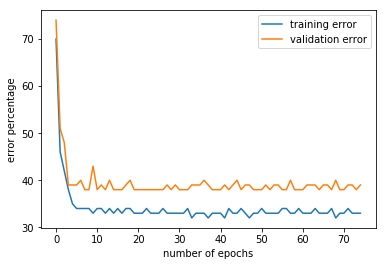

In [14]:
x = np.arange(num_epochs)

plt.figure()
plt.plot(x, train_err)
plt.plot(x, val_err)
plt.legend(['training error', 'validation error'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('error percentage')
plt.show()

### Evaluate the MLP

In [16]:
correct = 0
total = 0

# For each batch of images in test set
with torch.set_grad_enabled(False):
    for images, labels in test_loader:

      # Get the images
      images = images.view(-1, 28*28)

      images = images.to(device)

      # Find the output by doing a forward pass through the network
      outputs = net(images)

      # Find the class of each sample by taking a max across the probabilities of each class
      _, predicted = torch.max(outputs.data, 1)

      # Increment 'total', and 'correct' according to whether the prediction was correct or not
      total += labels.size(0)
      correct += (predicted.cpu() == labels).sum()

print('Test accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Test accuracy of the network on the 10000 test images: 61 %


### Excercise

Try the following and observe the effect on overfitting:
- Add more data to the training sample (the frac value).
- Change the weight associated with the L2 regularization (weight decay value in optimizer)
- Increase the number of training epochs (the hyper parameter: num_epochs)
- Simplify the model. Instead of two hidden layer, keep only one hidden layer with 512 neurons and observe the effect on overfitting.